In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

In [2]:
def inhomogenous_poisson_spikes(rate_t, dt):
    """
    generate spikes probabilistically within time bins of size `dt` according to a time-dependent rate `rate_t` 
    """
    spikes = np.random.rand(*rate_t.shape) < rate_t * dt
    spikes = np.array(np.where(spikes), dtype=float).T
    spikes[:, 1] *= dt
    return spikes

# Example: spikes with 2D latent model
Here, we construct spikes for $N$ neurons from time-dependent rates $\nu_i(t)$ that are linear combinations from a latend model with $z(t)$

Specifically, we choose 
$$
   z_1(t) = sin(2\pi t) + 1\\
   z_2(t) = sin(2\pi t + \pi/2) + 1
$$

(2, 5000)


Text(0.5, 1.0, 'Latent space')

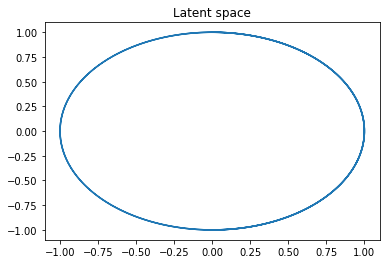

In [3]:
def z(t, omega):
    z_1 = np.sin(2*np.pi*omega*t)
    z_2 = np.cos(2*np.pi*omega*t)
    return np.vstack((z_1,z_2))

dt=0.001
T=5
ts=np.arange(0,T,dt)
zs=z(ts, 0.5)
print(zs.shape)
plt.plot(zs[0,:],zs[1,:]) 
plt.title("Latent space")

Then, we generate neural firing rates as linear combinations of the latent variables

$$
  \nu_i (t) = c_1*z_1(t) + c_2*z_2(t) + offset
$$

(32, 5000)
(32, 2)
(32, 5000)


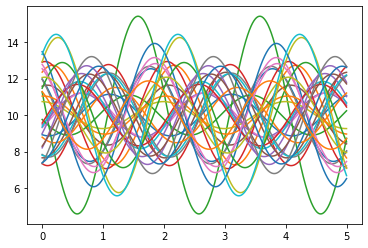

In [5]:
N = 32
mean_rate = 10
offset = np.ones((N,len(ts)))*mean_rate
print(offset.shape)
coefficients = 2*np.random.randn(N,2)
print(coefficients.shape)
drate_t = np.matmul(coefficients,zs)
print(drate_t.shape)
rate_t = offset + drate_t
plt.plot(ts, rate_t.T);
#plt.plot(np.mean(rates, axis=0));

In [6]:
pca = PCA()
pca.fit(rate_t)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[5.92900583e-01 4.07099417e-01 1.60476919e-30 1.55133419e-30
 8.07607550e-31 5.53058473e-33 5.53058473e-33 5.53058473e-33
 5.53058473e-33 5.53058473e-33 5.53058473e-33 5.53058473e-33
 5.53058473e-33 5.53058473e-33 5.53058473e-33 5.53058473e-33
 5.53058473e-33 5.53058473e-33 5.53058473e-33 5.53058473e-33
 5.53058473e-33 5.53058473e-33 5.53058473e-33 5.53058473e-33
 5.53058473e-33 5.53058473e-33 5.53058473e-33 5.53058473e-33
 5.53058473e-33 5.53058473e-33 5.53058473e-33 2.28422054e-33]
[5.70098669e+02 4.72399390e+02 9.37919095e-13 9.22171657e-13
 6.65363960e-13 5.50610658e-14 5.50610658e-14 5.50610658e-14
 5.50610658e-14 5.50610658e-14 5.50610658e-14 5.50610658e-14
 5.50610658e-14 5.50610658e-14 5.50610658e-14 5.50610658e-14
 5.50610658e-14 5.50610658e-14 5.50610658e-14 5.50610658e-14
 5.50610658e-14 5.50610658e-14 5.50610658e-14 5.50610658e-14
 5.50610658e-14 5.50610658e-14 5.50610658e-14 5.50610658e-14
 5.50610658e-14 5.50610658e-14 5.50610658e-14 3.53857255e-14]


To get a bit more realistic, let's generate actual spikes as an inhomogeneous poisson process

In [7]:
spikes = inhomogenous_poisson_spikes(rate_t, dt)
print(spikes)

[[ 0.     0.042]
 [ 0.     0.052]
 [ 0.     0.127]
 ...
 [31.     4.731]
 [31.     4.929]
 [31.     4.99 ]]


Follow analysis of https://www.nature.com/articles/s41593-019-0555-4

Bin spikes in windows of size 30ms

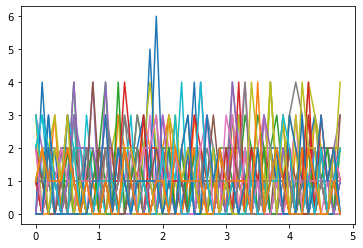

In [12]:
delta_t = 0.03
sd_t = 0.05
counts, _, time = np.histogram2d(spikes[:,0], spikes[:,1],bins=[np.arange(N+1),np.arange(0,T,delta_t)])
plt.plot(time[:-1], counts.T);

Now make square root transform

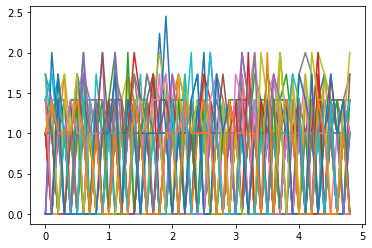

In [13]:
sqcounts = np.sqrt(counts)
plt.plot(time[:-1], sqcounts.T);

and apply Gaussian filter (with s.d. of 50ms)

(32, 49)


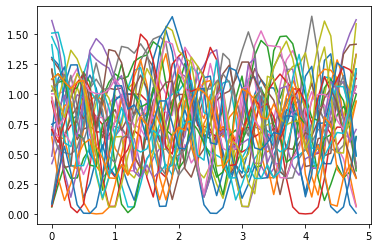

In [14]:
from scipy.ndimage import gaussian_filter1d
print(sqcounts.shape)
sd=sd_t/delta_t
signal = gaussian_filter1d(sqcounts, sigma=sd, axis=1)
plt.plot(time[:-1], signal.T);

(32, 49)
[1.70311162e-01 1.44474173e-01 1.04372764e-01 8.61018480e-02
 7.13909345e-02 6.05616476e-02 5.05187558e-02 4.67980881e-02
 3.80164018e-02 3.52879903e-02 3.17057033e-02 2.99388311e-02
 2.60858744e-02 2.29555787e-02 2.06036134e-02 1.61964802e-02
 1.02030569e-02 7.59187483e-03 6.75441869e-03 5.04115665e-03
 4.65825678e-03 2.76069553e-03 2.12692102e-03 1.56891197e-03
 1.42468952e-03 7.88514545e-04 6.26922712e-04 4.78009447e-04
 3.11835656e-04 1.85169773e-04 1.59719049e-04 5.28630882e-32]
[5.47366614e+00 5.04140813e+00 4.28499521e+00 3.89191176e+00
 3.54387408e+00 3.26404088e+00 2.98114480e+00 2.86926594e+00
 2.58608177e+00 2.49155347e+00 2.36170388e+00 2.29495497e+00
 2.14219720e+00 2.00955951e+00 1.90383122e+00 1.68797912e+00
 1.33974425e+00 1.15566316e+00 1.09006084e+00 9.41720110e-01
 9.05249848e-01 6.96892843e-01 6.11691478e-01 5.25358831e-01
 5.00629991e-01 3.72444532e-01 3.32096081e-01 2.89984636e-01
 2.34217658e-01 1.80485283e-01 1.67623578e-01 3.04953073e-15]


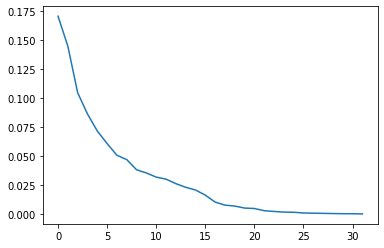

In [15]:
pca = PCA()
print(signal.shape)
pca.fit(signal)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)